In [3]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

In [4]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
ds = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')
ds

,package_name,review,date,star
0,com.mantz_it.rfanalyzer,Great app! The new version now works on my Bra...,October 12 2016,4
1,com.mantz_it.rfanalyzer,Great It's not fully optimised and has some is...,August 23 2016,4
2,com.mantz_it.rfanalyzer,Works on a Nexus 6p I'm still messing around w...,August 04 2016,5
3,com.mantz_it.rfanalyzer,The bandwidth seemed to be limited to maximum ...,July 25 2016,3
4,com.mantz_it.rfanalyzer,Works well with my Hackrf Hopefully new update...,July 22 2016,5
...,...,...,...,...
288060,com.termux.api,it doesn't do anything after installing this i...,June 24 2016,3
288061,com.termux.api,I like this app . Its is very helpful for use....,June 20 2016,5
288062,com.termux.api,Finally Brings back the Unix command line to A...,May 20 2016,5
288063,com.termux.api,The API feature is great just need loads more...,May 05 2016,5


In [6]:
list_ = []  
for i in range(len(ds['package_name'].unique())):
    ds_aux = ds.loc[ds['package_name'] == ds['package_name'].unique()[i]]
    #rescatamos en list_ los packages names unicos de todo el dataset
    list_.append({'package_name':ds['package_name'].unique()[i], 'size': len(ds_aux)})

#ordenamos de acuerdo al numero de datos de cada package name (de mayor a menor)
list_ = sorted(list_, key=lambda x: x['size'], reverse=True)

#seleccionamos el package name # 40 y almacenamos los reviews en el corpus
df = ds[ds['package_name'] == list_[40]['package_name']]
corpus = list(df['review'])

ds_new = pd.DataFrame(corpus)
print(ds_new)

                                                      0
0     Amazing Its great but can someone explain to m...
1     Seems this is one of the best app although I d...
2     Great; needs material design UI. Please use ma...
3                                             Great app
4                                          Cathy Female
...                                                 ...
1090  First time experimenting with this theorpy in ...
1091  Tried and true...no frills without the bells a...
1092                            One of the best so far.
1093              I quit smoking with the self hypnosis
1094   Helps me focus on work with kids running around!

[1095 rows x 1 columns]


In [7]:
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [8]:

def best_cluster_agglomerative(j):
    best_k = 0
    best_average = 0
    for k in range(2,j):

        agglomerative_clusterering = AgglomerativeClustering(n_clusters=k, affinity="cosine" , linkage="complete")
        cluster_labels = agglomerative_clusterering.fit_predict(corpus_embeddings)

        silhouette_avg = silhouette_score(corpus_embeddings, cluster_labels)
    
        if(silhouette_avg > best_average): 
            best_average = silhouette_avg
            best_k = k
            ds_new['clusters'] = cluster_labels

        #print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
        #print(cluster_labels)

      ##print("best avg: ", best_average)
      ##print("best k: ", best_k)

    return best_k, best_average

In [9]:
best_k_HC, best_average_HC = best_cluster_agglomerative(10)
print(best_k_HC)

7


In [10]:
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(corpus_embeddings)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

In [11]:
classes = []
for i in range(best_k_HC):
    classes.append('clusters '+ str(i+1))
print(classes)

['clusters 1', 'clusters 2', 'clusters 3', 'clusters 4', 'clusters 5', 'clusters 6', 'clusters 7']


In [12]:
clustering_model = AgglomerativeClustering(n_clusters=best_k_HC, affinity="cosine" , linkage="complete") #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(X_principal)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

[0 3 6 ... 6 0 5]


c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:1098: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


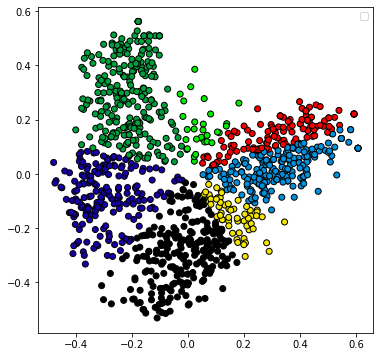

In [13]:
colors = cm.nipy_spectral(cluster_assignment.astype(float) / best_k_HC)
plt.figure(figsize =(6, 6))
scatter = plt.scatter(X_principal['P1'], X_principal['P2'],
                    c = colors,edgecolor='k')
                    
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

